In [1]:
import numpy as np
import torch

In [2]:
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
SAVE_PLOTS = True

In [3]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN
from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from tools.notify import notify
time_expector = TimeExpector()

In [4]:
batch_size = 4
nb_epochs = 2
nb_frame = 40

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print("Device:", device)

# test_run = True
# if test_run:
#     print('[WARNING] : This is test run.')

Device: cpu


In [5]:
%matplotlib inline

# FIXME
my_laptop = True
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
# def load_data(trail):
# #     if test_run:
# #         trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
#     if trail.startswith('acc'):
#         max_augmentation = 1
#         augmentation = False
#     else:
#         max_augmentation = 2 if trail == 'train' else 1
#         augmentation = True
    
#     trail = trail.replace('acc_', '')
#     return batchify(
#         trail,
#         DATASET_FOLDER_PATH,
#         CACHE_FOLDER_PATH,
#         condition_limit=['natural'],
#         batch_size=batch_size,
#         augmentation=augmentation,
#         max_augmentation=max_augmentation,
#         frame=nb_frame
#     )

original_size = 64
for __xb, __yb in batchify(
    'train',
    DATASET_FOLDER_PATH,
    CACHE_FOLDER_PATH,
    condition_limit=['natural'],
    batch_size=original_size,
    augmentation=False,
    max_augmentation=1,
    frame=nb_frame
):
    break

_hist = {i:0 for i in range(12)}
for i in __yb:
    _hist[i] += 1
max_value = max(_hist.values())

aug_xb = []
aug_yb = []
for i in range(12):
    idx = np.where(__yb == i)[0][0]
    to_add = max_value - _hist[i]
    for _ in range(to_add):
        aug_yb.append(i)
        aug_xb.append(__xb[idx, :, :, :])

print('pre augmentation size:')
print(__xb.shape)
print(__yb.shape)
__yb = np.concatenate([__yb, np.array(aug_yb)])
__xb = np.concatenate([__xb, np.array(aug_xb)])
print('\npost augmentation size:')
print(__xb.shape)
print(__yb.shape)


def load_data(trail):
    begin = 0
    end = begin + batch_size
    while end <= __yb.shape[0]:
        yield __xb[begin:end, :, :, :], __yb[begin:end]
        begin = end
        end = begin + batch_size

pre augmentation size:
(64, 40, 64, 64)
(64,)

post augmentation size:
(204, 40, 64, 64)
(204,)


pre-processing dataset: 51
pre-processing dataset: 51


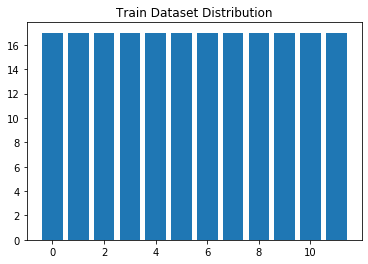

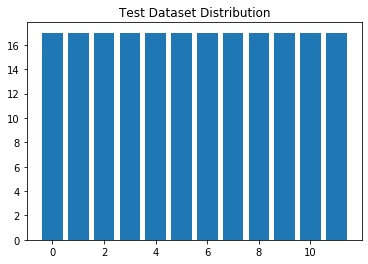

In [6]:
# calculate train dataset size
train_hist = {i:0 for i in range(12)}
test_hist = {i:0 for i in range(12)}
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    for i in y_batch:
        train_hist[i] += 1
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    for i in y_batch:
        test_hist[i] += 1
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

plt.bar(list(train_hist.keys()), list(train_hist.values()))
plt.title('Train Dataset Distribution')
plt.show()
plt.bar(list(test_hist.keys()), list(test_hist.values()))
plt.title('Test Dataset Distribution')
plt.show()

In [7]:
def plot_one_batch(network):
    for X_batch, _ in load_data('train'):
        break

    network.predict(X_batch)

    for i,l in enumerate(network.layers):
        if 'spk_rec_hist' in l.__dict__:
            print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        plot_spikes_in_time(l)

Layer 1: average number of spikes=0.2122


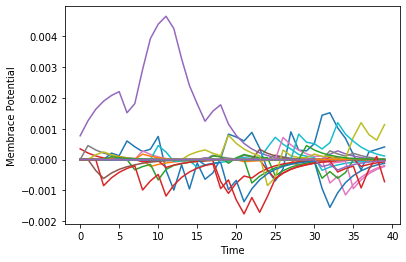

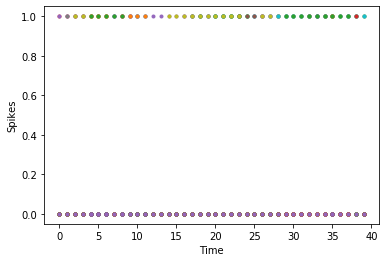

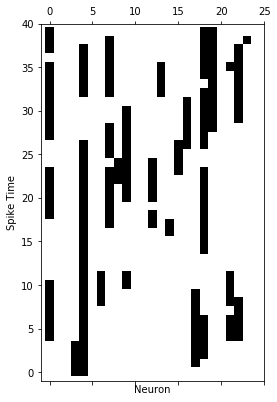

<Figure size 2160x1440 with 0 Axes>

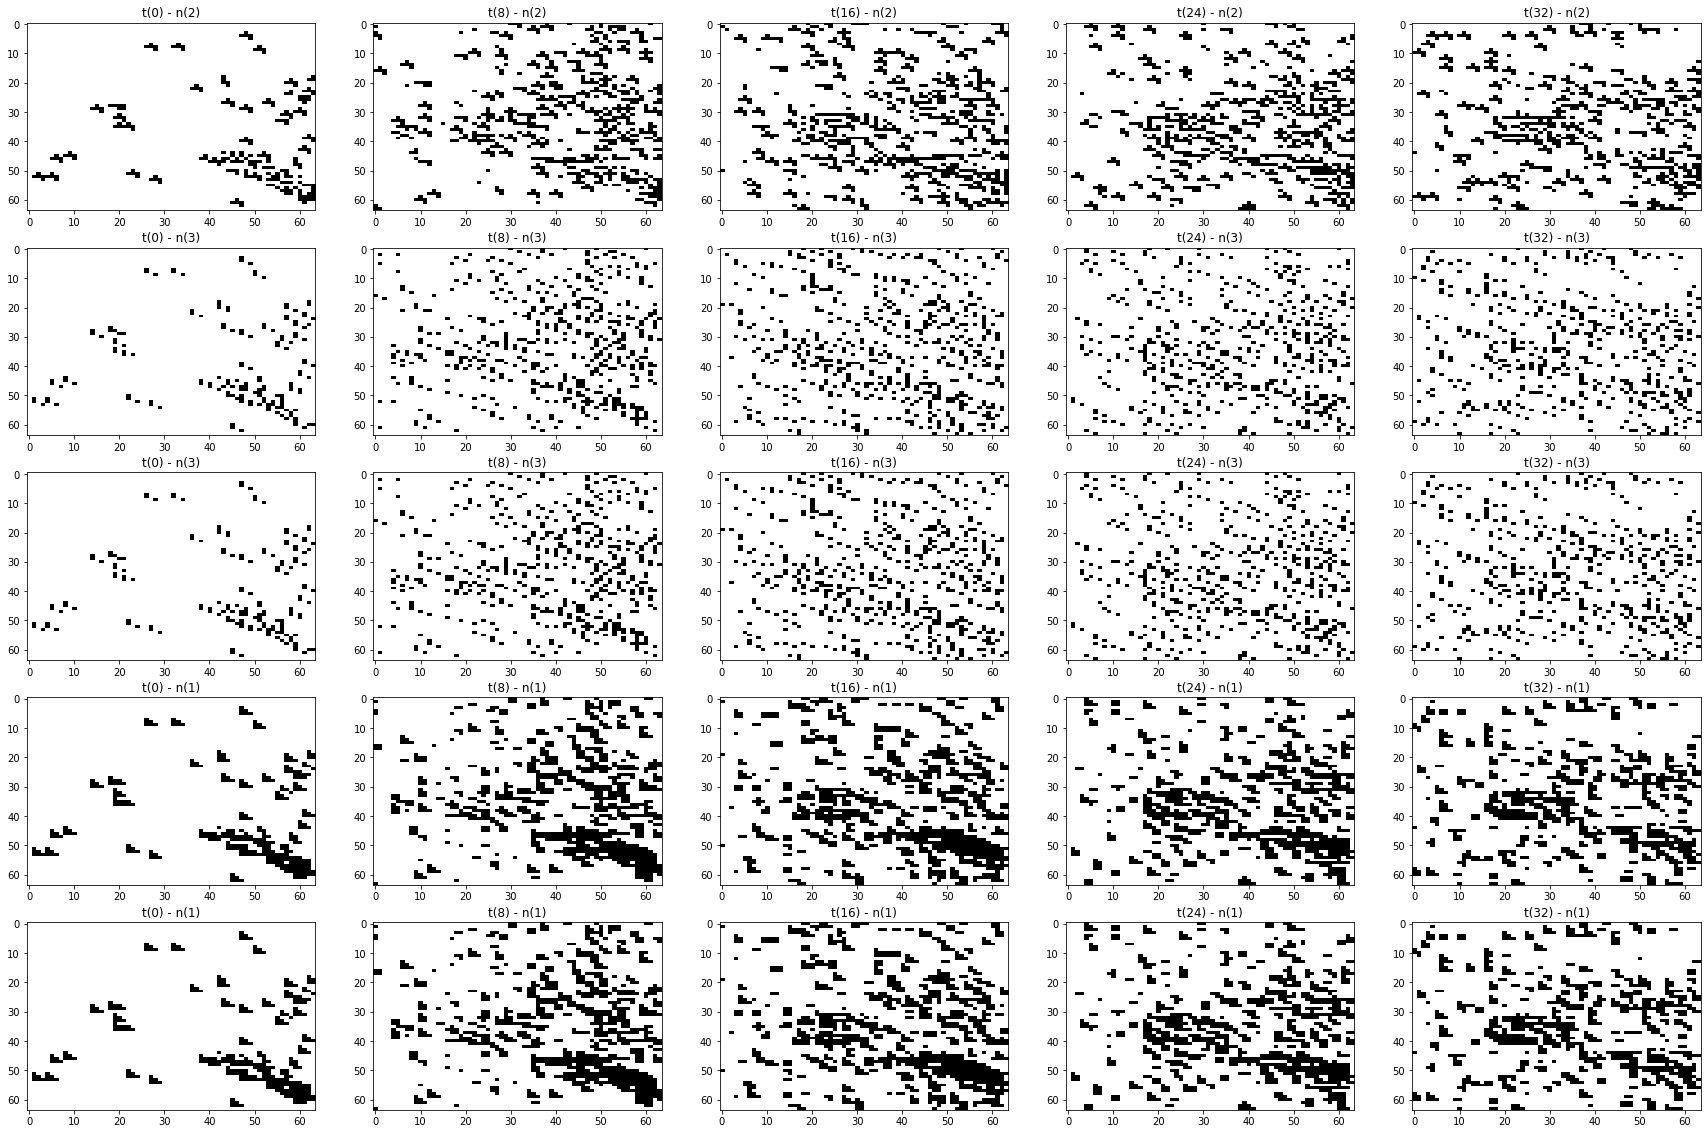

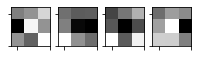

Layer 2: average number of spikes=0.9978


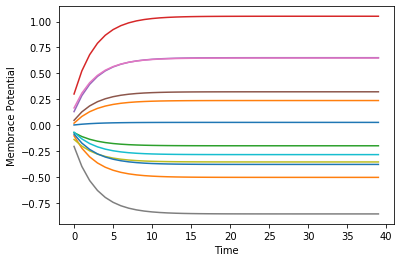

In [8]:
network = SNN(device=device, dtype=dtype)
network.time_expector = time_expector
network.notifier = notify


# tau_mem = 10e-3
# tau_syn = 5e-3
# time_step = 1e-3
# beta = float(np.exp(-time_step / tau_mem))
# weight_scale = 7*(1.0 - beta) # =.6

# network.add_dense(
#     input_shape=(64,64),
#     output_shape=128,              
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_conv3d(
    input_shape=(64,64),
    
    output_channels=4,#32,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
#     lateral_connections=True,
#     recurrent=True,
    
    w_init_mean=0.00,
    w_init_std=0.005
)
network.add_pool2d(kernel_size=(16,16))

# network.add_dense(
#     output_shape=128,
#     w_init_mean=0.0,
#     w_init_std=0.6
# #     lateral_connections=True
# )

network.add_readout(
    output_shape=12,
    time_reduction="max",

    w_init_mean=0.0,
    w_init_std=0.5
)

network.compile()
network = network.to(network.device, network.dtype) # FIXME: this is a bug, fix it!

plot_one_batch(network)

In [ ]:
with open('results.log', 'w+') as f:
    lr=0.01
    opt = RAdam(network.get_trainable_parameters(lr))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=nb_epochs,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=False
    )
    plot_metrics(res_metrics, save_plot_path='./metrics_' if SAVE_PLOTS else None)

# network.save('save_network.net')
# network.load('save_network.net')


Epoch: 0 [===========================================================>] 100%      | loss=2.750 val_loss=2.374
train_accuracy=15.69%  |  valid_accuracy=15.69%
[operation finished at 2020-05-12 12:48:36  -  took 1 minutes]
[expecting to finish at 2020-05-12 12:50:02]
Epoch: 1 [-------------------------------------------------------->...] 94%    

In [ ]:
plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./truth_' if SAVE_PLOTS else None
)

In [11]:
# network.predict(X_batch)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM or 'spk_rec_hist' not in l.__dict__:
#         continue
        
#     if isinstance(l, SpikingDenseLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, 0)

In [12]:
# Run on larger dataset
original_size = 700
for __xb, __yb in batchify(
    'test',
    DATASET_FOLDER_PATH,
    CACHE_FOLDER_PATH,
    condition_limit=['natural'],
    batch_size=original_size,
    augmentation=False,
    max_augmentation=1,
    frame=nb_frame
):
    break

_hist = {i:0 for i in range(12)}
for i in __yb:
    _hist[i] += 1
max_value = max(_hist.values())

aug_xb = []
aug_yb = []
for i in range(12):
    idx = np.where(__yb == i)[0][0]
    to_add = max_value - _hist[i]
    for _ in range(to_add):
        aug_yb.append(i)
        aug_xb.append(__xb[idx, :, :, :])

print('pre augmentation size:')
print(__xb.shape)
print(__yb.shape)
__yb = np.concatenate([__yb, np.array(aug_yb)])
__xb = np.concatenate([__xb, np.array(aug_xb)])
print('\npost augmentation size:')
print(__xb.shape)
print(__yb.shape)


def load_data(trail):
    begin = 0
    end = begin + batch_size
    while end <= __yb.shape[0]:
        yield __xb[begin:end, :, :, :], __yb[begin:end]
        begin = end
        end = begin + batch_size


# calculate train dataset size
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])


with open('results.log', 'w+') as f:
    lr=0.001
    opt = RAdam(network.get_trainable_parameters(lr))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=10,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=False
    )
    plot_metrics(res_metrics, save_plot_path='./metrics_B_' if SAVE_PLOTS else None)


plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./accuracy_B_' if SAVE_PLOTS else None
)

pre augmentation size:
(700, 40, 64, 64)
(700,)

post augmentation size:
(1548, 40, 64, 64)
(1548,)
pre-processing dataset: 387
pre-processing dataset: 387
[expecting to finish at 2020-05-12 12:49:40]
Epoch: 0 [----------------------------->..............................] 49%    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/aref/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-2d5e929e6ed2>", line 73, in <module>
    save_checkpoints=False
  File "/Users/aref/Workspace/action-recognition-via-snn/scnn/__init__.py", line 191, in fit
    l, n = self.batch_step(loss_func, x_batch, y_batch, optimizer)
  File "/Users/aref/Workspace/action-recognition-via-snn/scnn/__init__.py", line 248, in batch_step
    loss.backward()
  File "/Users/aref/.pyenv/versions/3.7.3/lib/python3.7/site-packages/torch/tensor.py", line 195, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/Users/aref/.pyenv/versions/3.7.3/lib/python3.7/site-packages/torch/autograd/__init__.py", line 99, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception

KeyboardInterrupt: 

In [ ]:

# Run on full dataset

def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 2 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=nb_frame
    )

dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])


with open('results.log', 'w+') as f:
    lr=0.0001
    opt = RAdam(network.get_trainable_parameters(lr))
#     opt = torch.optim.SGD(network.get_trainable_parameters(lr), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=3,
        optimizer=opt, 
        dataset_size=dataset_size, 
        result_file=f,
        save_checkpoints=False
    )
    plot_metrics(res_metrics, save_plot_path='./metrics_C_' if SAVE_PLOTS else None)

network.save('save_network.net')


plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./accuracy_C_' if SAVE_PLOTS else None
)